In [2]:
import os
import json
import qdrant_client
from typing import cast
from glob import glob
from pathlib import Path
from src.preprocess import (
    VideoIngestionPipeline,
    AppConfig,
    RunConfig,
    get_yt_id_from_url,
)
from llama_index.core.schema import QueryBundle
from llama_index.core import (
    PromptTemplate,
    Settings,
    SimpleDirectoryReader,
    StorageContext,
    set_global_handler,
)
from llama_index.core.base.llms.types import ChatMessage
from llama_index.core.base.response.schema import RESPONSE_TYPE
from llama_index.core.chat_engine.types import ChatMode
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.prompts.prompt_type import PromptType
from llama_index.core.query_engine import SimpleMultiModalQueryEngine
from llama_index.core.query_engine.multi_modal import _get_image_and_text_nodes
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageDocument, QueryBundle
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.vector_stores.qdrant import QdrantVectorStore
from src.video_to_index import video_to_index, chat
from llama_index.core.schema import ImageNode, NodeWithScore
from src.preprocess import VideoMetadata

In [3]:
run_config = RunConfig(seconds_per_frame=5)
# Create a local Qdrant vector store
db_client = qdrant_client.QdrantClient(path="qdrant_mm_db")

In [4]:
youtube_url = "https://www.youtube.com/watch?v=jG7dSXcfVqE"
youtube_id = get_yt_id_from_url(youtube_url)
save_dir = Path(f"data/{youtube_id}")
if not os.path.exists(save_dir):
    vid_pipe = VideoIngestionPipeline(AppConfig(save_dir=save_dir))
    video_metadata = vid_pipe.run(youtube_url, run_config)
else:
    metadata_file = glob(f"{save_dir}/metadata/*.json")
    video_metadata = cast(VideoMetadata, json.load(open(metadata_file[0], "r")))
# TODO: load if index are saved.
db_client.delete_collection(f"{video_metadata['id']}_text_collection")
db_client.delete_collection(f"{video_metadata['id']}_image_collection")

index = video_to_index(save_dir, db_client, video_metadata["id"])

Generating image embeddings: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


In [38]:
from src.video_to_index import gemini

DEFAULT_QA_TEMPLATE_STR = (
    f'You are responsible to answer the questions from a user about a video called "{video_metadata["title"]}.\n"'
    "You have the following components at hands:\n"
    "1. The first image: the image is from the user, COMPARE it with others image to answer the query.\n"
    "2. Other images: they are cuts from the videos, use them to compare with the first image.\n"
    "Other images information is below.\n"
    "---------------------\n"
    "{img_context_str}\n"
    "---------------------\n"
    "3. Video transcription: also use the video transcription as context information to answer the query.\n"
    "Transcription is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Use the components to correctly answer the query.\n\n"
    "User: {query_str}\n"
    "Assistant: "
)
DEFAULT_IMG_TEMPLATE_STR = (
    "Given the first image as the base image, use other images to "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

text_qa_tmpl = PromptTemplate(
    DEFAULT_QA_TEMPLATE_STR, prompt_type=PromptType.QUESTION_ANSWER
)
img_qa_tmpl = PromptTemplate(
    DEFAULT_IMG_TEMPLATE_STR, prompt_type=PromptType.QUESTION_ANSWER
)
query_engine = index.as_query_engine(
    llm=gemini,
    text_qa_template=text_qa_tmpl,
    image_qa_template=img_qa_tmpl,
    similarity_top_k=3,
    image_similarity_top_k=2,
)

In [39]:
query_bundle = QueryBundle(
    query_str="Give the timestamp of this scene.",
    # image_path="/Users/minhquang/Downloads/videoframe_105848.png"
    image_path="/Users/minhquang/Desktop/casey4.png",
)

In [40]:
query_engine = cast(SimpleMultiModalQueryEngine, query_engine)

print("Retrieving using text...")
text_nodes = query_engine.retrieve(query_bundle)
text_nodes_ids = [node.node_id for node in text_nodes]
print("Retrieving using image...")
img_nodes = query_engine._retriever.image_to_image_retrieve(query_bundle.image_path)
img_nodes = [node for node in img_nodes if node.node_id not in text_nodes_ids]
img_nodes, _ = _get_image_and_text_nodes(img_nodes)

nodes = img_nodes + text_nodes

Retrieving using text...
Retrieving using image...


In [41]:
def build_image_context_str(image_nodes):
    image_context_str = ""
    for i, image_node in enumerate(image_nodes):
        timestamp = image_node.node.metadata["timestamp"]
        image_context_str += f"Image {i} timestamp: {timestamp}\n"
    return image_context_str

In [42]:
image_nodes, text_nodes = _get_image_and_text_nodes(nodes)
context_str = "\n\n".join([r.get_content() for r in text_nodes])
img_context_str = build_image_context_str(image_nodes)

fmt_prompt = query_engine._text_qa_template.format(
    context_str=context_str,
    query_str=query_bundle.query_str,
    img_context_str=img_context_str,
)

In [43]:
print(fmt_prompt)

You are responsible to answer the questions from a user about a video called "DO WHAT YOU CAN'T.
"You have the following components at hands:
1. The first image: the image is from the user, COMPARE it with others image to answer the query.
2. Other images: they are cuts from the videos, use them to compare with the first image.
Other images information is below.
---------------------
Image 0 timestamp: 02:55
Image 1 timestamp: 00:45
Image 2 timestamp: 01:15
Image 3 timestamp: 03:10

---------------------
3. Video transcription: also use the video transcription as context information to answer the query.
Transcription is below.
---------------------
00:07: to the haters the doubters my
00:11: seventh-grade vice principal to everyone
00:14: who's ever told anyone with a dream they
00:16: can't this videos for you keep your head
00:24: down follow the rules do as you're told
00:27: play it safe wait your turn ask
00:29: permission learn to compromise this is
00:32: terrible advice if I we

In [44]:
query_img_node = ImageNode(image_path=query_bundle.image_path)
img_documents = [query_img_node] + [image_node.node for image_node in image_nodes]
llm_response = query_engine._multi_modal_llm.complete(
    prompt=fmt_prompt,
    image_documents=img_documents,
)

In [45]:
from llama_index.core.base.response.schema import Response

Response(
    response=str(llm_response),
    source_nodes=nodes,
    metadata={"text_nodes": text_nodes, "image_nodes": image_nodes},
)

Response(response=' The scene is Casey Neistat skateboarding on a bridge in New York City. The timestamp of this scene is 02:55.', source_nodes=[NodeWithScore(node=ImageNode(id_='1b87619e-794c-4657-b193-7be12c2b5331', embedding=None, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0035.png', 'file_name': 'do-what-you-cant-frame-0035.png', 'file_type': 'image/png', 'file_size': 357799, 'creation_date': '2024-03-24', 'last_modified_date': '2024-03-24', 'timestamp': '02:55'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='2bdf60bb-e197-471e-a628-658735af9629', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/minhquang/Desktop/spac

In [ ]:
# response = query_engine.synthesize(query_bundle=query_str, nodes=nodes)

# Trash


Query:
Which timestamp is this scene in?
 Assistant:
 The scene is at 02:54.
Retrieval: 3 images,  1 context.


**Node ID:** 67a203ac-507d-4254-9403-0d283a0d20c7<br>**Similarity:** 0.6174715036092122<br>**Text:** 00:07: to the haters the doubters my
00:11: seventh-grade vice principal to everyone
00:14: who's ever told anyone with a dream they
00:16: can't this videos for you keep your head
00:24: down follow the rules do as you're told
00:27: play it safe wait your turn ask
00:29: permission learn to compromise this is
00:32: terrible advice if I were to write an
00:36: autobiography a book not write one title
00:39: that would work with these do what you
00:41: can't because that idea encapsulate
00:43: everything I've ever done like what I
00:46: wanted to move to New York City and my
00:47: dad was like you can't you know anymore
00:49: or when I first said I wanted to make
00:51: movies it was you can't you didn't go to
00:54: film school I want to have a TV show
00:56: you can't Casey you're not pretty enough
01:02: characterize what this new generation of
01:06: content creators and filmmakers what we
01:09: all do on YouTube and everywhere else is
01:11: we do what we can't you can't be an
01:21: action movie filmmaker but you get your
01:23: Park or friends to dress up like video
01:25: game characters jump off some buildings
01:27: and you can let's see you know you're
01:37: interviewing the president I heard that
01:40: you're going to be out of a job so maybe
01:42: I'll start a YouTube show so I'm
01:43: thinking I can't fly around New York
01:45: City on a magic carpet but get your
01:47: electric skateboard some PVC pipes a
01:49: great outfit give Jesse a call and you
01:51: can what do you think this is so dope
01:55: you don't need gear you don't need
01:57: trucks or a crane you don't need
01:58: something expensive camera rig they
02:00: never work
02:01: when you're a creator you don't need
02:03: someone in your ear telling you what you
02:04: can and can't see what you can and can't
02:08: say I accidentally did the Shocker oh my
02:11: god
02:11: they call us gamers influencers internet
02:15: famous [ __ ] does that mean but we know
02:17: someth...<br>

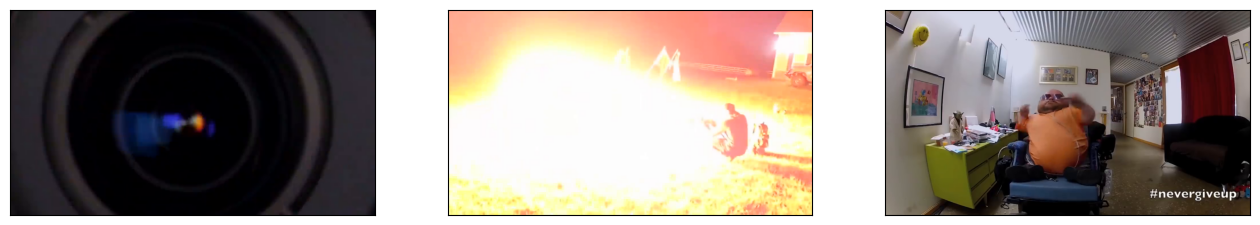

In [ ]:
text = "Which timestamp is this scene in?"
file = "/Users/minhquang/Desktop/casey.png"

response = chat(
    QueryBundle(query_str=text, image_path=file),
    [],
    index,
    video_metadata,
    return_context=True,
)

In [ ]:
from llama_index.core import set_global_handler

set_global_handler("simple")

In [ ]:
from src.video_to_index import gemini

In [ ]:
qa_tmpl = (
    "Context informatixon is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, try your best answer the query.\n"
    'If the query is not related to the video, kindly say "I can"t answer your question".'
    "User: {query_str}\n"
    "Assistant: "
)

In [ ]:
query_engine = index.as_query_engine(
    llm=gemini,
    text_qa_template=qa_tmpl,
    similarity_top_k=3,
    image_similarity_top_k=3,
)

In [ ]:
response = query_engine.query(
    QueryBundle(
        query_str="Is this person in the video?",
        image_path="https://storage.cloud.google.com/youtube_qa/videoframe_105848.png",
    )
)

In [ ]:
str(response)

' Yes, Casey Neistat is in the video.'

In [ ]:
from llama_index.core.query_engine import SimpleMultiModalQueryEngine
from llama_index.core.indices.multi_modal import MultiModalVectorIndexRetriever

In [ ]:
index.image_vector_store

QdrantVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=False, collection_name='jG7dSXcfVqE_image_collection', path=None, url=None, api_key=None, batch_size=64, parallel=1, max_retries=3, client_kwargs={}, enable_hybrid=False)

In [ ]:
qe = SimpleMultiModalQueryEngine(
    retriever=MultiModalVectorIndexRetriever(
        index=index, similarity_top_k=5, image_similarity_top_k=5
    ),
    multi_modal_llm=gemini,
)

In [ ]:
qe.query(
    QueryBundle(
        query_str="Is this person in the video?",
        image_path="https://storage.cloud.google.com/youtube_qa/videoframe_105848.png",
    )
)

Response(response=' Yes, the person in the video is Casey Neistat.', source_nodes=[NodeWithScore(node=TextNode(id_='67a203ac-507d-4254-9403-0d283a0d20c7', embedding=None, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/transcription/do-what-you-cant.txt', 'file_name': 'do-what-you-cant.txt', 'file_type': 'text/plain', 'file_size': 3067, 'creation_date': '2024-03-24', 'last_modified_date': '2024-03-24'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='685438a2-06cd-4e85-99c3-6544949eff01', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/transcription/do-what-you-cant.txt', 'file_name': 'do-what-you-cant.tx

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://storage.googleapis.com/youtube_qa/videoframe_105848.png",
    # Add yours here!
]

image_documents = load_image_urls(image_urls)

In [ ]:
from llama_index.core import SimpleDirectoryReader

image_documents = SimpleDirectoryReader(str(data_dir / "img")).load_data()

https://storage.googleapis.com/youtube_qa/videoframe_105848.png


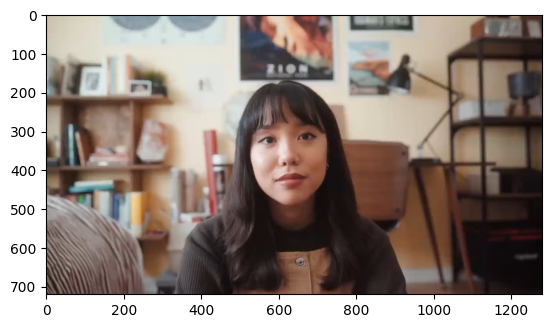

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

In [ ]:
retriever = MultiModalVectorIndexRetriever(
    index=index, similarity_top_k=5, image_similarity_top_k=2
)

In [ ]:
retrieval_results = retriever.image_to_image_retrieve(
    QueryBundle(
        query_str="What the hell is this shit?",
        image_path="/Users/minhquang/Downloads/videoframe_105848.png",
    )
)

In [ ]:
retrieval_results

[NodeWithScore(node=ImageNode(id_='8dba0457-a7b6-4783-8579-d95deb13cbc2', embedding=None, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0026.png', 'file_name': 'do-what-you-cant-frame-0026.png', 'file_type': 'image/png', 'file_size': 546056, 'creation_date': '2024-03-24', 'last_modified_date': '2024-03-24', 'timestamp': '02:10'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='21ab5466-9544-4fe4-9c28-affcaf0c29d9', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0026.png', 'file_name': 'do-what-you-cant-frame-0026.png', 'file_type': 'image/png', 'fil

In [ ]:
retrieval_results = retriever.image_to_image_retrieve(
    "/Users/minhquang/Downloads/videoframe_105848.png"
)

In [ ]:
retrieval_results

[NodeWithScore(node=ImageNode(id_='8dba0457-a7b6-4783-8579-d95deb13cbc2', embedding=None, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0026.png', 'file_name': 'do-what-you-cant-frame-0026.png', 'file_type': 'image/png', 'file_size': 546056, 'creation_date': '2024-03-24', 'last_modified_date': '2024-03-24', 'timestamp': '02:10'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='21ab5466-9544-4fe4-9c28-affcaf0c29d9', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0026.png', 'file_name': 'do-what-you-cant-frame-0026.png', 'file_type': 'image/png', 'fil

In [ ]:
qe._retriever.image_to_image_retrieve(
    "/Users/minhquang/Downloads/videoframe_105848.png"
)

[NodeWithScore(node=ImageNode(id_='8dba0457-a7b6-4783-8579-d95deb13cbc2', embedding=None, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0026.png', 'file_name': 'do-what-you-cant-frame-0026.png', 'file_type': 'image/png', 'file_size': 546056, 'creation_date': '2024-03-24', 'last_modified_date': '2024-03-24', 'timestamp': '02:10'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='21ab5466-9544-4fe4-9c28-affcaf0c29d9', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0026.png', 'file_name': 'do-what-you-cant-frame-0026.png', 'file_type': 'image/png', 'fil

In [82]:
retriever = index.as_retriever(similartity_top_k=3, image_similarity_top_k=2)
retriever = cast(MultiModalVectorIndexRetriever, retriever)

default_context = retriever.retrieve(query)

In [ ]:
i2i_context = retriever.image_to_image_retrieve(query)

In [110]:
default_context[0].node_id

'67a203ac-507d-4254-9403-0d283a0d20c7'

In [83]:
# query only use text_to_image_retrieve, how to use image_to_image_retrieve?
print(qa_tmpl)

Context informatixon is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, try your best answer the query.
If the query is not related to the video, kindly say "I can"t answer your question".User: {query_str}
Assistant: 


In [ ]:
# gemini.complete(
#     prompt="Given the first image as the base image, "
# )

In [ ]:
"if input with image: change the prompt like Given the first image and the query, use the context and others image to answer the question:"

In [84]:
from llama_index.core.schema import NodeWithScore
from typing import List

# use this class to create the custom query engine: SimpleMultiModalQueryEngine()


class CustomRetriever(MultiModalVectorIndexRetriever):
    def _retrieve(
        self,
        query_bundle: QueryBundle,
    ) -> List[NodeWithScore]:
        res = []
        # If text vector store is not empty, retrieve text nodes
        # If text vector store is empty, please create index without text vector store
        if self._vector_store is not None:
            res.extend(self._text_retrieve(query_bundle))

        # If image vector store is not empty, retrieve text nodes
        # If image vector store is empty, please create index without image vector store
        if self._image_vector_store is not None:
            res.extend(self._text_to_image_retrieve(query_bundle))
            res.extend(self.image_to_image_retrieve(query_bundle))

        return res

In [ ]:
image_qa_template = 

In [88]:
query_engine = SimpleMultiModalQueryEngine(
    retriever=CustomRetriever(
        index=index, similarity_top_k=5, image_similarity_top_k=2
    ),
    multi_modal_llm=gemini,
)

In [104]:
query = QueryBundle(
    query_str="Does this man appear in the video? Who is this man?",
    image_path="/Users/minhquang/Desktop/casey.png",
)
response = query_engine.query(query)

In [105]:
image_prompt = (
    "Given the first image as the base image, use other images to "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [106]:
default_qe = index.as_query_engine(
    llm=gemini,
    image_qa_template=image_prompt,
    similarity_top_k=3,
    image_similarity_top_k=3,
)
response = default_qe.image_query(query.image_path, query.query_str)

In [107]:
response

Response(response=' The man in the first image is the famous Youtuber Roman Atwood. He is known for his prank videos and vlogs. He has over 10 million subscribers on Youtube.', source_nodes=[NodeWithScore(node=ImageNode(id_='bb17a258-ff4c-4bad-a724-6cdc7a4959e2', embedding=None, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/data/jG7dSXcfVqE/img/do-what-you-cant-frame-0009.png', 'file_name': 'do-what-you-cant-frame-0009.png', 'file_type': 'image/png', 'file_size': 662959, 'creation_date': '2024-03-24', 'last_modified_date': '2024-03-24', 'timestamp': '00:45'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='d2e276f1-7d91-404e-b2e3-15df3aaf0297', node_type=<ObjectType.DOCUMENT: '4'>, metadat